# Bradley-Terry Modeling of NBA Teams

In this notebook we'll use a dataset of all games in NBA history from [kaggle](https://www.kaggle.com/datasets/eoinamoore/historical-nba-data-and-player-box-scores). We'll show how to load general competition or paired comparison datasets using `arena` and compute Bradley-Terry based leaderboards 

Steps:
1. Download and process the dataset.
2. Compute ratings and confidence intervals using `arena`
3. Analyze the leaderboards for all time, and for the 2025/2026 season

In [1]:
import kagglehub
import pandas as pd

from arena.utils.data_utils import PairDataset
from arena.models.bradley_terry import BradleyTerry
from example_utils import plot_leaderboard

### Preprocessing
In order to use a dataset in `arena` we need to process it into the required format where the df must have:
* Two columns which identify the competitors of each match. For this we will map team ids found in the `hometeamId` and `awayteamId` columns to the names most recently used by those teams. (Many teams have renamed over time)
* A column which represents the outcome of the game. The original dataset has a column `winner` which contains the id of winning team. We map that to a column that contains either `"home"` or `"away"`

That's enough to get started with `arena`!

In [2]:
path = kagglehub.dataset_download("eoinamoore/historical-nba-data-and-player-box-scores")
df = pd.read_csv(f"{path}/Games.csv", low_memory=False)


def get_team_id_to_name_mapping(df):
    # map team_id to most recent team_name from home/away columns
    home = df[["gameDateTimeEst", "hometeamId", "hometeamName"]].rename(
        columns={"hometeamId": "team_id", "hometeamName": "team_name"}
    )
    away = df[["gameDateTimeEst", "awayteamId", "awayteamName"]].rename(
        columns={"awayteamId": "team_id", "awayteamName": "team_name"}
    )
    all_teams = pd.concat([home, away]).sort_values("gameDateTimeEst").drop_duplicates(subset="team_id", keep="last")
    return dict(zip(all_teams["team_id"], all_teams["team_name"]))


id_to_name = get_team_id_to_name_mapping(df)
df["home"] = df["hometeamId"].map(id_to_name)
df["away"] = df["awayteamId"].map(id_to_name)
df["winner"] = df.apply(lambda row: "home" if row["winner"] == row["hometeamId"] else "away", axis=1)
df = df[["gameDateTimeEst", "home", "away", "winner"]]
df

,gameDateTimeEst,home,away,winner
0,2025-12-10 17:00:00,Lakers,Spurs,away
1,2025-12-10 14:30:00,Thunder,Suns,home
2,2025-12-09 15:30:00,Raptors,Knicks,away
3,2025-12-09 13:00:00,Magic,Heat,home
4,2025-12-08 15:00:00,Pelicans,Spurs,away
...,...,...,...,...
72306,1946-12-08 19:00:00,Knicks,Celtics,home
72307,1946-12-07 19:00:00,Celtics,Knicks,away
72308,1946-12-05 19:00:00,Warriors,Knicks,home
72309,1946-11-30 19:00:00,Knicks,Warriors,home


### Modeling
To compute the leaderboard we:
1. Create a `PairDataset` object from the dataframe, specifying the columns we created, and how to the values of "winner" column map to outcomes. We represent a home win as 1.0, and an away win as 0.0. (There are no ties in basketball but if there were we would map them to 0.5).
2. Create the `BradleyTerry` model object
3. Fit the model on the dataset using `compute_ratings_and_cis`



In [3]:
dataset = PairDataset.from_pandas(
    df,
    competitor_cols=["home", "away"],
    outcome_col="winner",
    outcome_map={"home": 1.0, "away": 0.0},
    reweighted=False,
)

model = BradleyTerry(n_competitors=dataset.n_competitors, init_rating=1200)

# compute ratings and 95% confidence intervals
results = model.compute_ratings_and_cis(dataset, significance_level=0.05)
competitors = dataset.competitors

### Leaderboard Visualization
We can plot the ratings and confidence intervals and recover a ranking of teams using all 72,000 games from NBA history.

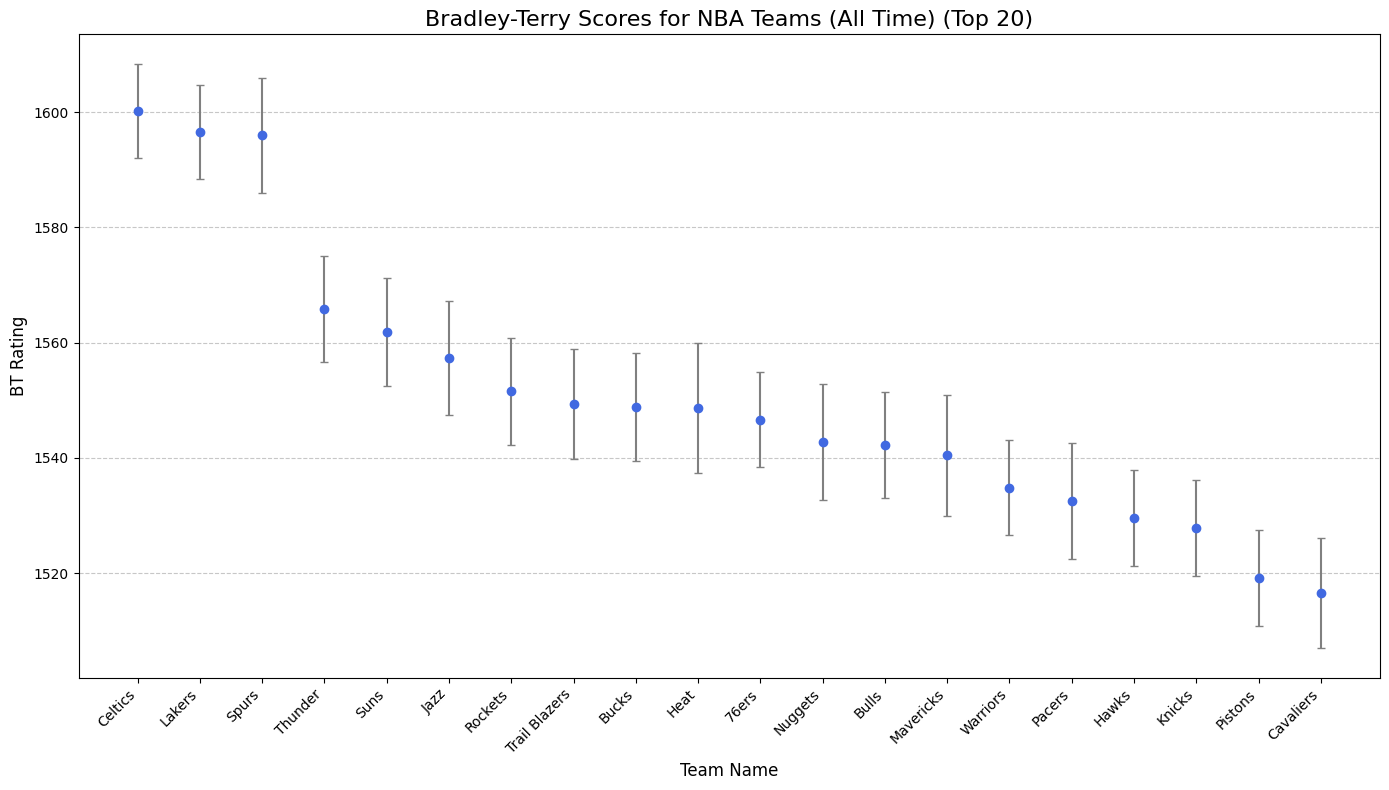

In [4]:
plot_leaderboard(
    results,
    competitors,
    top_n=20,
    title="Bradley-Terry Scores for NBA Teams (All Time)",
    item_name="Team",
    rating_name="BT Rating",
)

### Results
The Celtics, Lakers, and Spurs being the clear top 3 does accurately reflect NBA history, but this isn't the best example since team strengths have changed massively over the 80 year history of the NBA. The Bradley-Terry model works better or smaller spans without drastic changes. Let's look at just the 2025-2026 season next.

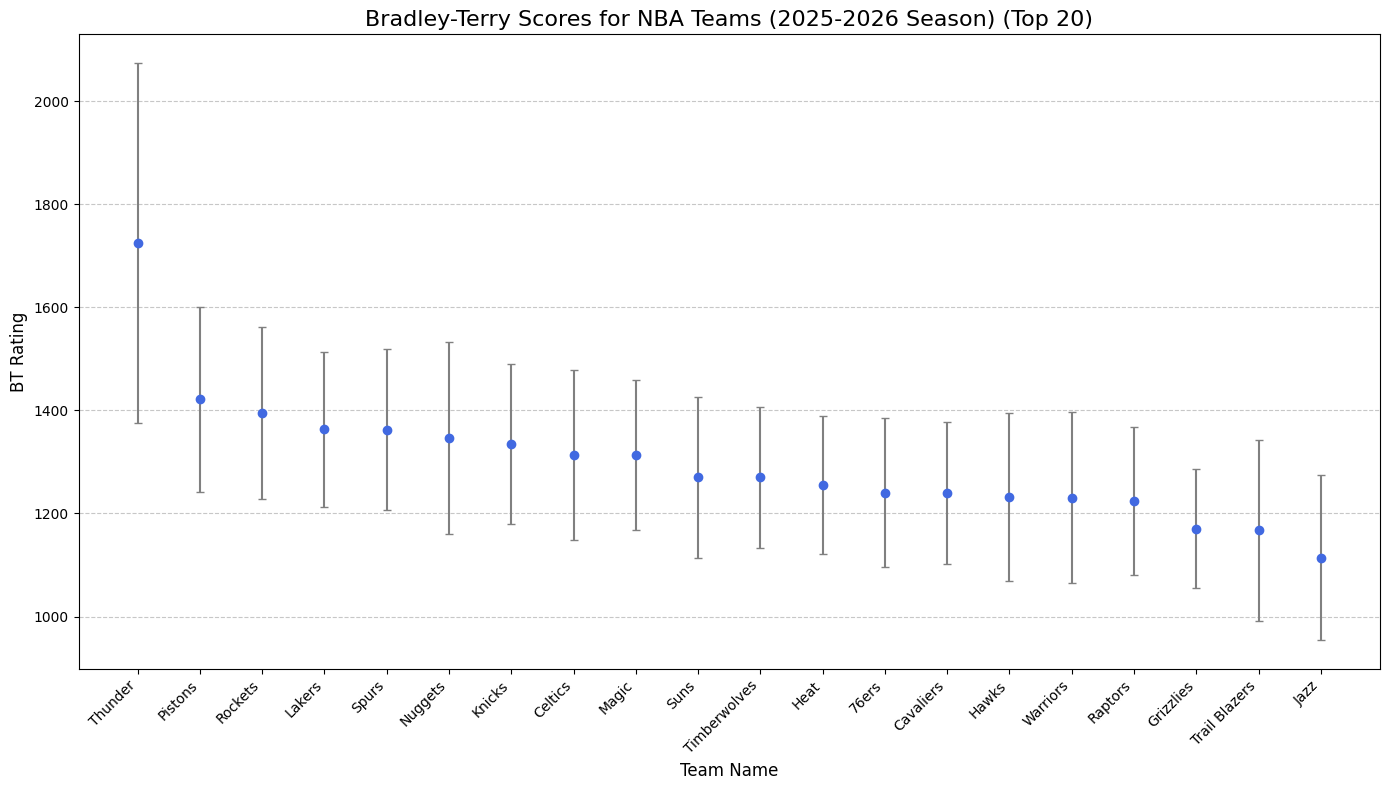

In [7]:
# look at just the last season
recent_df = df[(df["gameDateTimeEst"].str[:10] >= "2025-10-20") & (df["gameDateTimeEst"].str[:10] <= "2026-10-01")]
recent_dataset = PairDataset.from_pandas(
    recent_df,
    competitor_cols=["home", "away"],
    outcome_col="winner",
    outcome_map={"home": 1.0, "away": 0.0},
    reweighted=False,
)
recent_model = BradleyTerry(
    n_competitors=recent_dataset.n_competitors,
    init_rating=1200,
)
recent_results = recent_model.compute_ratings_and_cis(recent_dataset, significance_level=0.05)
recent_competitors = recent_dataset.competitors
plot_leaderboard(
    recent_results,
    recent_competitors,
    top_n=20,
    title="Bradley-Terry Scores for NBA Teams (2025-2026 Season)",
    item_name="Team",
    rating_name="BT Rating",
)

As of December 11th 2025, the Thunder are 24-1 so this big lead makes sense. Also seeing the Pistons at #2 after like 2 decades of them sucking is super cool.